In [1]:
import numpy as np
import pandas as pd
import quantecon as qe
from ast import literal_eval
from sklearn.ensemble import RandomForestRegressor
import ternary
import random
import plotly.figure_factory as ff
import colorsys
from matplotlib import pyplot as plt

In [2]:
def creating_samples(samples_number, random_samples_number, element):
    gen=0
    #Creating uniform samples
    uniform_samples = (-qe.simplex_grid(len(element), 1)+1)/(len(element)-1)
    uniform_number = samples_number - random_samples_number
    uniform_samples = uniform_samples[random.sample(range(0, len(uniform_samples)), uniform_number), :]
    
    #Creating random samples
    if random_samples_number > 0:
        random_samples = np.random.rand((random_samples_number), len(element))
        for i in range(random_samples_number):
            random_samples[i] = np.around(random_samples[i]/sum(random_samples[i]), decimals = 3)
        sample = np.vstack((uniform_samples, random_samples))
    else:
        sample = uniform_samples
    
    #Joining the samples
    samples = []
    for i in range(samples_number):
        samples.append(list(sample[i]))
    samples = np.array(samples)
    samples = np.around(samples, decimals = 3)
    
    #Creating "Generation" column
    generation = []
    for i in range (samples_number):
            generation.append(gen)
    
    #Creating "ID" column
    ID = np.arange(1, (samples_number+1))

    data = {'ID' : ID, 'Elements': [element], 'Generation': generation}
    df = pd.DataFrame(data=data, index = np.arange(samples_number))
    df = pd.concat([df, pd.DataFrame(([[i] for i in samples]), columns = ['Position'])], axis = 1)
      
    df.to_csv("Result/Initial Population.txt", sep='\t', index=False, mode='w')
    return df

In [3]:
#Loading data and fitting
df_old = pd.read_csv('Data/AuIrOsPdPtReRhRu_0.60_compositions_and_targets.csv')
X_columns_old = ['Pt','Pd','Au','Ru','Rh','Ir','Re','Os']
x_old = df_old[X_columns_old].to_numpy()
y_old = df_old['current_over_capacitance'].to_numpy()

#Rndom Forest Regression
reg = RandomForestRegressor(n_estimators = 1024,
                           bootstrap = True,
                           max_depth = None,
                           max_features = 'auto',
                           min_samples_leaf = 1,
                           min_samples_split = 2,
                           oob_score = True)
reg = reg.fit(x_old, y_old)

In [4]:
#Making Class
class pso:
    def __init__ (self, data, magnitude_limit=0.20, target = None):
        self.datalog = data
        #Reading "Elements" columns from string to list
        self.datalog['Elements'] = self.datalog["Elements"].apply(lambda x: literal_eval(x))
        
        #Select latest generation
        self.generation = self.datalog['Generation'].max()
        
        #Creating np.array of "Position" column and dropping the string type "Position" column
        self.position = []
        for i in range(self.datalog['ID'].max()):
            self.position.append(list(np.fromstring(self.datalog['Position'][i][1:-1], dtype=float, sep=' ')))
        self.position = np.array(self.position)
        self.datalog = self.datalog.drop(columns=['Position'])
        self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.position]), columns = ['Position'])], axis = 1)
        
        #Creating target vector
        if target == None:
            target = []
            for i in range(len(self.datalog['Elements'][0])):
                target.append(1/len(self.datalog['Elements'][0]))
            target = np.array(target)
            target = np.around(target, decimals = 3)
        
        #Creating "Velocity" column for the "0" generation
        if self.generation == 0:
            self.velocity = np.around((-(self.position - target)), decimals = 3)
            #Turning velocity into unit vector with certain magnitude
            self.velocity = self.unit_vector_velocity(magnitude_limit)
            self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.velocity]), columns = ['Velocity'])], axis = 1)      
           
        #Creating blank "Activity" column
        self.datalog = pd.concat([self.datalog, pd.DataFrame(columns = ['Activity'], index = np.arange(self.datalog['ID'].max()))], axis = 1)      
   
        #Filling the "Activity" column with RFR
        self.f_activity(self.datalog)
            
        #Creating dataframe of the latest generation
        self.working_generation = self.datalog.loc[self.datalog['Generation']==self.generation]
 
    
    def create_new_velocity(self, factor_1, factor_2, factor_3, factor_4, mutation_rate, mutation_prob, magnitude_limit):
        #Creating new velocity
        for i in range(len(self.working_generation)):
            new_velocity = -(factor_1 * self.working_generation.at[i, 'Velocity'] + 
                        factor_2 * self.delta_individual_best((i+1), 'Activity') * self.delta_individual_best((i+1), 'Position') +
                        factor_3 * self.delta_gen_best((i+1), 'Activity') * self.delta_gen_best((i+1), 'Position') + 
                        factor_4 * self.delta_g_best((i+1), 'Activity') * self.delta_g_best((i+1), 'Position'))       
           #Mutation process
            self.working_generation.at[i,'Velocity'] = self.mutate(new_velocity, mutation_rate, mutation_prob, magnitude_limit)
            
        #Normalization
        self.normalize_velocity()
        #Limitting velocity
        self.limitting_velocity(magnitude_limit)
        return
    
    
    def change_position(self):
        #Changing position
        for i in range(len(self.working_generation)):    
            new_position = self.working_generation.at[i, 'Position'] + self.working_generation.at[i, 'Velocity']
            #Bouncing process if the position in the outside of the spaces
            if new_position.max() > 1 or new_position.min() < 0:
                #Bouncing the velocity
                self.working_generation.at[i, 'Velocity'] = self.correct_velocity(new_position, self.working_generation.at[i, 'Velocity'])
                #Correcting the position
                new_position = self.correct_position(new_position)
            self.working_generation.at[i,'Position'] = np.around(new_position, decimals = 3)
        return
        

    def correct_velocity(self, new_position, velocity):
        #Changing the sign of velocity which belongs to position outside the spaces  
        bounced_velocity_0 = np.where(new_position < 0, velocity * -1, velocity)
        bounced_velocity_1 = np.where(new_position > 1, bounced_velocity_0 * -1, bounced_velocity_0)
        #Normalizing the velocity
        normalized_velocity = bounced_velocity_1 - (sum(bounced_velocity_1)/len(self.working_generation['Elements'][0]))
        #Preserving the magnitude of velocity
        unit_velocity = normalized_velocity/np.sqrt(sum(normalized_velocity**2))
        corrected_velocity = unit_velocity * np.sqrt(sum(bounced_velocity_1**2))
        corrected_velocity = np.around(corrected_velocity, decimals = 3)
        return corrected_velocity


    def correct_position(self, new_position):
        while new_position.max() > 1 or new_position.min() < 0:
            correction = []
            for i in range(len(self.working_generation['Elements'][0])):
                if new_position[i] > 1:
                    #Fill the previous column of correction by 1/(n-1) of the correction
                    for x in range(i):
                        correction.append(-2*(1 - new_position[i])/(len(self.working_generation['Elements'][0])-1))
                    #Fill column of correction
                    correction.append(2*(1 - new_position[i]))
                    #Fill the next column of correction by 1/(n-1) of the correction
                    for x in range(len(self.working_generation['Elements'][0])-1-i):
                        correction.append(-2*(1 - new_position[i])/(len(self.working_generation['Elements'][0])-1))

                if new_position[i] < 0:
                    #Fill the previous column of correction by 1/(n-1) of the correction
                    for x in range(i):
                        correction.append(-2*(0 - new_position[i])/(len(self.working_generation['Elements'][0])-1))
                    #Fill column of correction
                    correction.append(2*(0 - new_position[i]))
                    #Fill the next column of correction by 1/(n-1) of the correction
                    for x in range(len(self.working_generation['Elements'][0])-1-i):
                        correction.append(-2*(0 - new_position[i])/(len(self.working_generation['Elements'][0])-1))

            correction = np.array(correction)
            correction = np.reshape(correction, (int(len(correction)/len(self.working_generation['Elements'][0])), len(self.working_generation['Elements'][0])))

            #Add the correction to the old position 
            for i in range(len(correction)):
                 new_position = new_position + correction[i]
        return new_position
    
    
    
    def move(self, factor_1, factor_2, factor_3, factor_4, mutation_rate, mutation_prob, magnitude_limit):
        #Updating generation
        self.generation += 1
        self.working_generation['Generation'] += 1
        
        #Updating velocity
        self.create_new_velocity(factor_1, factor_2, factor_3, factor_4, mutation_rate, mutation_prob, magnitude_limit)     
        
        #Updating position
        self.change_position()
        
        #Filling the "Activity" column with RFR
        self.f_activity(self.working_generation)
        
        #Concating the tables
        self.datalog = pd.concat([self.datalog, self.working_generation])
        self.datalog = self.datalog.reset_index(drop=True)
        self.store_datalog()
        return 

    
    
    def f_activity(self, dataframe):
        global reg
        global X_columns_old
        list_of_zeros = [0] * (len(X_columns_old) - len(self.datalog['Elements'][0]))
        for i in range(len(dataframe)):
            dataframe.at[i, 'Activity'] = float(reg.predict(np.reshape((np.hstack((dataframe.at[i, 'Position'], list_of_zeros))), (1, -1))))
        return 

   
    def unit_vector_velocity(self, magnitude_limit):
        self.unit_vector_velocity = []
        for i in range(self.datalog['ID'].max()):
            self.unit_vector_velocity.append(list(self.velocity[i]/np.sqrt(sum(self.velocity[i]**2))))
        self.unit_vector_velocity = np.array(self.unit_vector_velocity) * magnitude_limit
        self.unit_vector_velocity = np.around(self.unit_vector_velocity, decimals = 3)
        return self.unit_vector_velocity
    
    def normalize_velocity(self):
        for i in range(len(self.working_generation)):
            self.working_generation.at[i, 'Velocity'] = self.working_generation.at[i, 'Velocity'] - (sum(self.working_generation.at[i, 'Velocity'])/len(self.working_generation['Elements'][0]))
            self.working_generation.at[i, 'Velocity'] = np.around(self.working_generation.at[i, 'Velocity'], decimals= 3)
        return

    def limitting_velocity(self, magnitude_limit):
        for i in range(len(self.working_generation)):
            if np.sqrt(sum(self.working_generation.at[i, 'Velocity']**2)) > magnitude_limit:
                self.working_generation.at[i, 'Velocity'] = self.working_generation.at[i, 'Velocity'] / np.sqrt(sum(self.working_generation.at[i, 'Velocity']**2)) * magnitude_limit
                self.working_generation.at[i, 'Velocity'] = np.around(self.working_generation.at[i, 'Velocity'], decimals= 3)
        return
    
    def mutate(self, new_velocity, mutation_rate, mutation_prob, magnitude_limit):
        mutated_velocity = []
        for i in range(len(new_velocity)):
            mutation = np.random.rand()
            step_size_i = 0
            if mutation < mutation_prob:
                step_size_i = np.random.uniform((0-mutation_rate), (0+mutation_rate))
            mutated_velocity.append(new_velocity[i] + magnitude_limit * step_size_i)
        mutated_velocity = np.array(mutated_velocity)
        return mutated_velocity
    
   
    def g_best(self):
        return self.datalog.loc[np.argmin(self.datalog['Activity'])]
    
    def gen_best(self):
        return self.working_generation.loc[np.argmin(self.working_generation['Activity'])]
           
    def individual_best(self, ID):
        self.i_data = self.datalog[self.datalog['ID']==ID].reset_index(drop=True)
        return self.i_data.loc[np.argmin(self.i_data['Activity'])]
    
    def delta_g_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.g_best()[parameter]
    
    def delta_gen_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.gen_best()[parameter]
    
    def delta_individual_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.individual_best(ID)[parameter]      
    
    
    def individual_log(self, ID):
        return self.datalog[self.datalog['ID']==ID].reset_index(drop=True)
    
    def store_datalog(self):
        self.datalog.to_csv("Result/Initial Population_gen "+str(self.generation)+".txt", sep='\t', index=False, mode='w')
        return
    

In [5]:
class grid:
    def __init__(self, data, grid_len):
        self.datalog = data
        self.datalog = self.datalog[['ID', 'Elements', 'Generation', 'Position', 'Activity']]
        self.grid_len = grid_len
        self.generation = self.datalog['Generation'].max()
        
        #Creating "Region" column
        self.determine_grid_points()
        self.determine_region()
        self.datalog['Region'] = self.region
    
        #Creating "Visited" column
        self.visited = []
        for i in range(len(self.datalog)):
            check = self.datalog.at[i, 'Region'] == self.datalog.loc[0:(i-1)]['Region']
            if np.count_nonzero(check) == 0:
                self.visited.append(False)
            else:
                self.visited.append(True)
        self.datalog['Visited'] = self.visited
        
        #Renaming index column
        self.datalog.index.name = 'Experiment'
        

    def determine_grid_points(self):
        simplex_grid = qe.simplex_grid(len(self.datalog['Elements'][0]), self.grid_len)/self.grid_len

        #Translating Vector
        translation = 1/(self.grid_len*len(self.datalog['Elements'][0]))
        translating_vector = [-(len(self.datalog['Elements'][0])-1)*translation]
        for i in range(len(self.datalog['Elements'][0])-1):
            translating_vector.append(translation)
        translating_vector = np.array(translating_vector)                  
        
        #Making grid
        grid_points_1 = simplex_grid + translating_vector
        grid_points_2 = simplex_grid + 2*translating_vector
        self.grid_points = np.vstack((grid_points_1, grid_points_2))
        self.grid_points = np.around(self.grid_points, decimals = 4)
        self.grid_points = self.grid_points[self.grid_points[:, 0].argsort()]

        #Deleting grid points outside the space
        self.grid_points = np.delete(self.grid_points, np.where(self.grid_points<0)[0], axis = 0)
        self.grid_points = np.delete(self.grid_points, np.where(self.grid_points>1)[0], axis = 0)
        return
    
    def determine_region(self):
        #Determining region
        self.region = []
        for i in range(len(self.datalog)):
            distance = []
            for x in range(len(self.grid_points)):
                distance.append(np.sqrt(sum((self.datalog.at[i, 'Position']-self.grid_points[x])**2)))
            distance = np.array(distance)
            self.region.append(distance.argmin())
        self.region = np.array(self.region)
        return
      
    def count_occurences(self):
        #Count Occurrences of Each Grid
        self.grid_count = []
        for i in range(len(self.grid_points)):
            self.grid_count.append((self.datalog['Region'] == i).sum())
        self.grid_count = np.array(self.grid_count)
        return
    
    def create_grid_table(self):
        self.count_occurences()
        #Creating Exploration Table
        self.grid_table = pd.DataFrame(([[self.datalog['Elements'][0]] for i in self.grid_points]), columns = ['Elements'])
        self.grid_table = pd.concat([self.grid_table, pd.DataFrame(([[i] for i in self.grid_points]), columns = ['Point'])], axis = 1)
        self.grid_table['Region'] = np.arange(len(self.grid_points))
        self.grid_table['Count'] = self.grid_count
        for i in range(len(self.grid_table)):
            self.grid_table.at[i, 'First visit'] = self.datalog[self.datalog['Region'] == i].index.min()       
        return self.grid_table
    
    def exploitation_value(self):
        self.exploitation_data = []
        for i in range(self.generation+1):
            max_observation = self.datalog[0:(i+1)*self.datalog['ID'].max()]
            self.exploitation_data.append(1-(len(np.unique(max_observation['Region'])))/len(max_observation))
        self.exploitation_data = np.array(self.exploitation_data)
        self.exploitation_data = np.around(self.exploitation_data, decimals = 3)
        return self.exploitation_data[-1]
    
    def exploration_value(self):
        self.exploration_data = []
        for i in range(self.generation+1):
            max_observation = self.datalog[0:(i+1)*self.datalog['ID'].max()]
            self.exploration_data.append(len(np.unique(max_observation['Region']))/len(self.grid_points))
        self.exploration_data = np.array(self.exploration_data)
        self.exploration_data = np.around(self.exploration_data, decimals = 3)
        return self.exploration_data[-1]
        
    def exploitation_bar_chart(self, min_number = 3):
        self.create_grid_table()
        #Creating table for bar chart
        self.exploitation_bar_chart_table = self.grid_table.loc[self.grid_table['Count'] >= min_number].reset_index(drop=True)
        self.exploitation_bar_chart_table['Region'] = self.exploitation_bar_chart_table['Region'].astype(str)
        for i in range(len(self.exploitation_bar_chart_table['Point'])):
            self.exploitation_bar_chart_table.at[i, 'Point'] = np.around(self.exploitation_bar_chart_table.at[i, 'Point'], decimals = 2)
        self.exploitation_bar_chart_table['Point'] = self.exploitation_bar_chart_table['Point'].astype(str)
        
        #Plotting
        fig, ax = plt.subplots(figsize =(10, 7))

        #Horizontal Bar Plot
        ax.barh(self.exploitation_bar_chart_table['Point'], self.exploitation_bar_chart_table['Count'],
                color ='blue')
        
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.xlabel('Count', fontsize = 12)
        plt.ylabel('Point ' + str(self.datalog['Elements'][0]), fontsize = 12)
        plt.show()
        return
        
    def exploration_vs_generation(self):
        self.exploration_value()
        y = self.exploration_data
        x = np.arange(self.generation+1)
            
        #Plotting
        fig = plt.figure(figsize = (10, 7))

        plt.plot(x, y, marker = 'o', color = 'blue')
        plt.xticks(np.arange(0, self.generation+1, 5), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.ylim(-0.05, 1)
        plt.xlabel('Generation', fontsize = 12)
        plt.ylabel('Exploration', fontsize = 12)
        plt.show()
        return
    
    def exploitation_vs_generation(self):
        self.exploitation_value()
        y = self.exploitation_data
        x = np.arange(self.generation+1)
        
        #Plotting
        fig = plt.figure(figsize = (10, 7))

        plt.plot(x, y, marker = 'o', color = 'blue')
        plt.xticks(np.arange(0, self.generation+1, 5), fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.ylim(-0.05, 1)
        plt.xlabel('Generation', fontsize = 12)
        plt.ylabel('Exploitation', fontsize = 12)
        plt.show()
        return

In [6]:
class find_best:
    def __init__(self, data):
        self.datalog = data
        self.datalog = self.datalog[['ID', 'Elements', 'Generation', 'Position', 'Activity']]
        self.generation = self.datalog['Generation'].max()
    
    def g_best(self):
        return self.datalog.loc[np.argmin(self.datalog['Activity'])]
    
    def find_distance(self, target):
        self.distance = []
        for i in range(len(self.datalog)):
            self.distance.append(np.sqrt(sum((self.datalog.at[i, 'Position']-target)**2)))
        self.distance = np.array(self.distance)
        self.distance = np.around(self.distance, decimals = 3)
        return
    
    def first_to_reach_limit(self, target, limit):
        self.find_distance(target)
        if len(np.array(np.where(self.distance < limit))[0]) == 0:
            result = None
        else:
            result = self.datalog.loc[np.array(np.where(self.distance < limit)).min()]
        return result
    
    def min_value_vs_generation(self):
        self.min_value = []
        for i in range(self.generation+1):
            self.min_value.append(self.datalog.loc[self.datalog['Generation'] <= i]['Activity'].min())
        self.min_value_vs_generation_table = pd.DataFrame((np.arange(self.generation+1)), columns = ['Generation'])
        self.min_value_vs_generation_table['min_value'] = self.min_value
        
        #Plotting
        fig = plt.figure(figsize = (10, 7))
        
        plt.plot(self.min_value_vs_generation_table['Generation'], self.min_value_vs_generation_table['min_value'], marker = 'o', color = 'blue')
        plt.xticks(np.arange(0, self.generation+1, 5), fontsize = 12)
        plt.ylim(-1.2, -0.4)
        plt.yticks(fontsize = 12)
        plt.xlabel("Generation", fontsize = 12)
        plt.ylabel("Min Value", fontsize = 12)
        plt.show()
        return
      
   
    def distance_vs_generation(self, target):
        self.find_distance(target)
        #Creating Distance vs Generation Table
        self.distance_value = []
        for i in range(self.generation+1):
            self.distance_value.append(self.distance[0:(self.datalog['ID'].max()*(i+1))].min())
        self.distance_value_vs_generation_table = pd.DataFrame((np.arange(self.generation+1)), columns = ['Generation'])
        self.distance_value_vs_generation_table['Distance'] = self.distance_value
        

        #Plotting
        fig = plt.figure(figsize = (10, 7))
        plt.plot(self.distance_value_vs_generation_table['Generation'], self.distance_value_vs_generation_table['Distance'], marker = 'o', color = 'blue')
        plt.ylim(-0.05, 0.5)
        plt.yticks(fontsize = 12)
        plt.xticks(np.arange(0, self.generation+1, 5), fontsize = 12)
        plt.xlabel('Generation', fontsize = 12)
        plt.ylabel('Distance', fontsize = 12)
        plt.show()
        return

In [7]:
samples_number = 10
random_samples_number = 5
element = ['Pt','Pd','Au','Ru','Rh','Ir','Re','Os']
creating_samples(samples_number, random_samples_number, element)

,ID,Elements,Generation,Position
0,1,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.143, 0.0, 0.143..."
1,2,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.0, 0.143, 0.143, 0.143..."
2,3,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.0, 0.143, 0.143, 0.143, 0.143..."
3,4,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.0, 0.143, 0.143, 0.143, 0.143, 0.143..."
4,5,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.1..."
5,6,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.01, 0.115, 0.188, 0.094, 0.186, 0.065, 0.14..."
6,7,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.141, 0.121, 0.137, 0.19, 0.102, 0.125, 0.05..."
7,8,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.18, 0.129, 0.065, 0.178, 0.115, 0.184, 0.08..."
8,9,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.105, 0.091, 0.16, 0.015, 0.186, 0.159, 0.06..."
9,10,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.016, 0.259, 0.224, 0.016, 0.179, 0.125, 0.0..."


In [15]:
magnitude_limit = 0.3
population = pso(pd.read_csv('Result/Initial Population.txt', sep='\t'), magnitude_limit)

In [16]:
population.datalog

,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.143, 0.0, 0.143...","[-0.04, -0.04, -0.04, -0.04, -0.04, 0.28, -0.0...",-0.414124
1,2,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.0, 0.143, 0.143, 0.143...","[-0.04, -0.04, -0.04, 0.28, -0.04, -0.04, -0.0...",-0.374152
2,3,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.0, 0.143, 0.143, 0.143, 0.143...","[-0.04, -0.04, 0.28, -0.04, -0.04, -0.04, -0.0...",-0.273501
3,4,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.0, 0.143, 0.143, 0.143, 0.143, 0.143...","[-0.04, 0.28, -0.04, -0.04, -0.04, -0.04, -0.0...",-0.247126
4,5,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.1...","[-0.04, -0.04, -0.04, -0.04, -0.04, -0.04, -0....",-0.210922
5,6,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.01, 0.115, 0.188, 0.094, 0.186, 0.065, 0.14...","[0.196, 0.017, -0.107, 0.053, -0.104, 0.102, -...",-0.164633
6,7,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.141, 0.121, 0.137, 0.19, 0.102, 0.125, 0.05...","[-0.048, 0.012, -0.036, -0.197, 0.07, -0.0, 0....",-0.284578
7,8,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.18, 0.129, 0.065, 0.178, 0.115, 0.184, 0.08...","[-0.123, -0.009, 0.134, -0.118, 0.022, -0.132,...",-0.249173
8,9,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.105, 0.091, 0.16, 0.015, 0.186, 0.159, 0.06...","[0.033, 0.056, -0.057, 0.18, -0.1, -0.056, 0.1...",-0.305725
9,10,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.016, 0.259, 0.224, 0.016, 0.179, 0.125, 0.0...","[0.137, -0.169, -0.125, 0.137, -0.068, -0.0, 0...",-0.195428


In [17]:
factor_1 = 0.95 #damping factor
factor_2 = 0.8 #individual's record factor
factor_3 = 1.2 #neighbor factor
factor_4 = 1.5   #global's record factor
mutation_prob = 0.7
mutation_rate = 0.5

for i in range(20):
    population.move(factor_1, factor_2, factor_3, factor_4, mutation_rate, mutation_prob, magnitude_limit)
    print(population.g_best()['Position'], population.g_best()['Activity'])

[0.155 0.15  0.143 0.383 0.012 0.068 0.053 0.036] -0.5698241015625014
[0.256 0.156 0.146 0.165 0.013 0.013 0.074 0.175] -0.6296733984375011
[0.256 0.156 0.146 0.165 0.013 0.013 0.074 0.175] -0.6296733984375011
[0.253 0.205 0.13  0.237 0.012 0.022 0.005 0.143] -0.693410996093751
[0.273 0.294 0.104 0.091 0.072 0.026 0.007 0.131] -0.7709969433593711
[0.3   0.26  0.158 0.048 0.083 0.004 0.025 0.12 ] -0.8460012792968709
[0.3   0.26  0.158 0.048 0.083 0.004 0.025 0.12 ] -0.8460012792968709
[0.342 0.152 0.199 0.076 0.006 0.045 0.019 0.155] -0.9151978613281211
[0.428 0.184 0.139 0.063 0.005 0.028 0.    0.147] -0.9995287988281227
[0.428 0.184 0.139 0.063 0.005 0.028 0.    0.147] -0.9995287988281227
[0.428 0.184 0.139 0.063 0.005 0.028 0.    0.147] -0.9995287988281227
[0.428 0.184 0.139 0.063 0.005 0.028 0.    0.147] -0.9995287988281227
[0.428 0.184 0.139 0.063 0.005 0.028 0.    0.147] -0.9995287988281227
[0.374 0.212 0.162 0.03  0.011 0.03  0.003 0.169] -1.0133164550781213
[0.42  0.132 0.182 0.

In [11]:
bayes_2000_best = np.array([0.397, 0.243, 0.288, 0.037, 0.   , 0.   , 0.   , 0.035])
np.sqrt(sum((population.g_best()['Position']-bayes_2000_best)**2))

0.14853955702101715

In [12]:
gridding = grid(population.datalog, grid_len = 14)

In [13]:
gridding.datalog

,ID,Elements,Generation,Position,Activity,Region,Visited
Experiment,,,,,,,
0,1,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.0, 0.143, 0.143, 0.143...",-0.363298,58051,False
1,2,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.143, 0.143, 0.0...",-0.307042,57834,False
2,3,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.0, 0.143, 0.143, 0.143, 0.143...",-0.275902,58277,False
3,4,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.0, 0.143, 0.143...",-0.381921,57877,False
4,5,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",0,"[0.143, 0.143, 0.143, 0.143, 0.143, 0.0, 0.143...",-0.437405,57781,False
...,...,...,...,...,...,...,...
205,6,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",20,"[0.295, 0.131, 0.067, 0.007, 0.006, 0.079, 0.1...",-0.835994,112650,False
206,7,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",20,"[0.352, 0.034, 0.08, 0.067, 0.035, 0.006, 0.18...",-0.875314,121886,False
207,8,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]",20,"[0.399, 0.152, 0.011, 0.036, 0.002, 0.033, 0.2...",-0.962397,121532,False


In [14]:
gridding.create_grid_table()

,Elements,Point,Region,Count,First visit
0,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]","[0.0089, 0.0089, 0.0089, 0.0089, 0.0089, 0.008...",0,0,NaN
1,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]","[0.0089, 0.2232, 0.0089, 0.4375, 0.2232, 0.008...",1,0,NaN
2,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]","[0.0089, 0.2232, 0.5089, 0.0089, 0.0804, 0.008...",2,0,NaN
3,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]","[0.0089, 0.2232, 0.5089, 0.0089, 0.0804, 0.008...",3,0,NaN
4,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]","[0.0089, 0.2232, 0.5089, 0.0089, 0.0804, 0.008...",4,0,NaN
...,...,...,...,...,...
127903,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]","[0.8661, 0.0089, 0.0089, 0.0089, 0.0089, 0.008...",127903,0,NaN
127904,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]","[0.8661, 0.0089, 0.0089, 0.0089, 0.0089, 0.008...",127904,0,NaN
127905,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]","[0.8661, 0.0804, 0.0089, 0.0089, 0.0089, 0.008...",127905,0,NaN
127906,"[Pt, Pd, Au, Ru, Rh, Ir, Re, Os]","[0.875, 0.0179, 0.0179, 0.0179, 0.0179, 0.0179...",127906,0,NaN


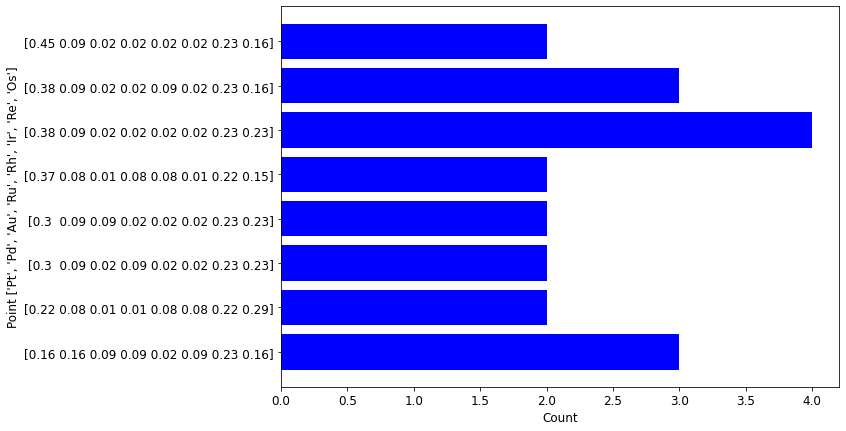

In [16]:
gridding.exploitation_bar_chart(2)

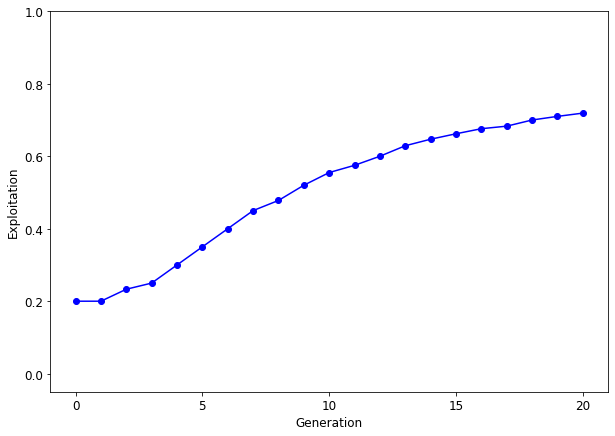

In [54]:
gridding.exploitation_vs_generation()

In [28]:
gridding.exploitation_value()

0.733

In [ ]:
gridding.exploration_vs_generation()

In [24]:
pso = find_best(population.datalog)

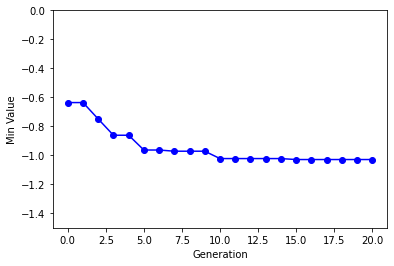

In [25]:
pso.min_value_vs_generation()

In [39]:
pso.g_best()

ID                                                            1
Elements                       [Pt, Pd, Au, Ru, Rh, Ir, Re, Os]
Generation                                                   15
Position      [0.348, 0.295, 0.274, 0.009, 0.004, 0.014, 0.0...
Activity                                               -1.02908
Name: 150, dtype: object

In [38]:
pso.first_to_reach_limit(pso.g_best()['Position'], 0.1)

ID                                                            7
Elements                       [Pt, Pd, Au, Ru, Rh, Ir, Re, Os]
Generation                                                   10
Position      [0.279, 0.341, 0.284, 0.04, 0.016, 0.006, 0.00...
Activity                                              -1.022422
Name: 106, dtype: object

In [37]:
pso.distance[pso.distance>0].min()

0.034

In [32]:
np.sqrt(sum((pso.first_to_reach_limit(pso.g_best()['Position'], 0.1)['Position']-bayes_2000_best)**2))

0.1544506393641671

In [27]:
pso.first_to_reach_limit(bayes_2000_best, 0.1)

ID                                                            1
Elements                       [Pt, Pd, Au, Ru, Rh, Ir, Re, Os]
Generation                                                   15
Position      [0.348, 0.295, 0.274, 0.009, 0.004, 0.014, 0.0...
Activity                                               -1.02908
Name: 150, dtype: object

In [44]:
#Benchmarking
factor_1 = 0.95 #damping factor
factor_2 = 0.8 #individual's record factor
factor_3 = 1.2 #neighbor factor
factor_4 = 1.5   #global's record factor
mutation_prob = 0.7
mutation_rate = 0.5

for i in range (20):
    magnitude_limit = 0.3
    population = pso(pd.read_csv('Result/Initial Population.txt', sep='\t'), magnitude_limit)
    for x in range(30):
        population.move(factor_1, factor_2, factor_3, factor_4, mutation_rate, mutation_prob, magnitude_limit)
    population.datalog.to_csv('Data_PSO/PSO_' + str(i) + '.txt', sep='\t', index=False, mode='w')

In [ ]:
magnitude_limit = 0.3
population = pso(pd.read_csv('Result/Initial Population_manual.txt', sep='\t'), magnitude_limit, target = None)

In [ ]:
population.datalog

In [ ]:
factor_1 = 0.95 #damping factor
factor_2 = 1.2 #individual's record factor
factor_3 = 0.5 #neighbor factor
factor_4 = 1.5   #global's record factor
mutation_prob = 0.7
mutation_rate = 0.5
magnitude_limit = 0.3

for i in range(20):
    population.move(factor_1, factor_2, factor_3, factor_4, mutation_rate, mutation_prob, magnitude_limit)
    display(population.working_generation)
    print(population.g_best()['Position'], population.g_best()['Activity'])
    print(np.sqrt(sum((population.g_best()['Position']-best_grid)**2)))

In [ ]:
population.exploration_scatter()

In [ ]:
population.g_best()

In [ ]:
gridding = benchmark(population.datalog, grid_len = 10)

In [ ]:
gridding.datalog

In [ ]:
gridding.exploitation_bar_chart(9)

In [ ]:
gridding.exploitation_vs_generation()

In [ ]:
gridding.grid_table.sort_values(by = 'Count', ascending = False)[0:10]

In [ ]:
gridding.exploitation_value()